In [275]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from textblob import TextBlob
from gensim.models import Word2Vec

Populating the interactive namespace from numpy and matplotlib


#### Test Model

This uses a few committees to just get started with modeling

In [9]:
# ag_maj_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/agriculture/majority.pkl")
# ag_min_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/agriculture/minority.pkl")
fr_maj_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/foreign_relations/chairman.pkl")
fr_min_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/foreign_relations/ranking_member.pkl")
comm_min_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/commerce/democratic.pkl")
comm_maj_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/commerce/republican.pkl")
bank_min_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/banking/democratic.pkl")
bank_maj_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/banking/republican.pkl")


In [99]:
fr_maj_df["Committee"] = "Foreign Relations"
fr_maj_df["Party"] = "Republican"
fr_maj_df["Label"] = "Foreign Relations, Republican"
fr_min_df["Committee"] = "Foreign Relations"
fr_min_df["Party"] = "Democratic"
fr_min_df["Label"] = "Foreign Relations, Democratic"

comm_maj_df["Committee"] = "Commerce"
comm_maj_df["Party"] = "Republican"
comm_maj_df["Label"] = "Commerce, Republican"
comm_min_df["Committee"] = "Commerce"
comm_min_df["Party"] = "Democratic"
comm_min_df["Label"] = "Commerce, Democratic"

bank_maj_df["Committee"] = "Banking"
bank_maj_df["Party"] = "Republican"
bank_maj_df["Label"] = "Banking, Republican"
bank_min_df["Committee"] = "Banking"
bank_min_df["Party"] = "Democratic"
bank_min_df["Label"] = "Banking, Democratic"

In [100]:
arr = [fr_maj_df, fr_min_df, comm_min_df, comm_maj_df, bank_min_df, bank_maj_df]

In [102]:
all_df = pd.concat(arr)
all_df.Party.value_counts()

Democratic    2085
Republican    1811
Name: Party, dtype: int64

3896

In [ ]:
# tfidf = TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words=my_stops, 
#                         token_pattern="\\b[a-z][a-z]+\\b", ngram_range=(1,2))
# all_platforms = list(platforms["Platform"])
# corpus = list()
# lengths = defaultdict(int)
# for index, platform in enumerate(all_platforms):
#     sents = nltk.sent_tokenize(platform)
#     lengths[index] += len(sents)
#     corpus += sents
# plat_tf = tfidf.fit_transform(corpus)
# nmf = NMF(n_components=10, init='random', random_state=42)

In [27]:
my_stops = stopwords.words()
all_releases = list(all_df["Release"])
corpus = list()
lengths = defaultdict(int)
for index, release in enumerate(all_releases):
    sents = nltk.sent_tokenize(release)
    lengths[index] += len(sents)
    corpus += sents

In [314]:
tfidf = TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words=my_stops, 
                        token_pattern="\\b[a-z][a-z]+\\b", ngram_range=(1,2))

In [318]:
rel_tf = tfidf.fit_transform(corpus)
nmf = NMF(n_components=150, init="random", random_state=42)

In [319]:
rel_nmf = nmf.fit_transform(rel_tf)

In [320]:
for topic_idx, topic in enumerate(nmf.components_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([tfidf.get_feature_names()[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic #0:
senate senate committee vote passed banking chairman senate senate foreign senate gov office gov
Topic #1:
foreign relations foreign relations relations committee senate foreign committee chairman senate menendez kerry bob
Topic #2:
administration obama department response effort actions action commitment syria concerns
Topic #3:
financial institutions services markets regulatory oversight banking banks rules office
Topic #4:
member ranking ranking member member senate senate committee affairs urban foreign relations released bob
Topic #5:
region syria interests regime across weapons threat commitment part actions
Topic #6:
including significant assistance nations trade programs past russian actions foreign
Topic #7:
one home colleagues going part human clear foreign witnesses past
Topic #8:
www gov senate gov commerce senate www commerce https https www index commerce cfm
Topic #9:
help create protect better jobs markets effort witnesses assistance access
Topic #10:
years pa

In [34]:
def get_release_scores(releases, lengths):
    counter = 0
    rel_scores = list()
    for length in lengths:
        end_point = counter + length
        test = releases[counter:end_point]
        test_avg = test.mean(axis=0)
        counter = end_point
        #print(counter)
        rel_scores.append(test_avg)
    return rel_scores

In [76]:
def get_rel_scores(releases):
    final = list()
    for release in releases:
        if len(release) > 0:
            #print(len(release))
            sents = nltk.sent_tokenize(release)
            sents_tf = tfidf.transform(sents)
            sents_nmf = nmf.transform(sents_tf)
            test = sents_nmf.mean(axis=0)
            final.append(test)
    return final
        

In [132]:
def get_rel_score(release):
    #print(len(release))
    if len(release) >0:
        sents = nltk.sent_tokenize(release)
        sents_tf = tfidf.transform(sents)
        sents_nmf = nmf.transform(sents_tf)
        score = sents_nmf.mean(axis=0)
    else:
        score = [0]
    return list(score)

In [321]:
all_df["Topic_Score"] = all_df.apply(lambda row: get_rel_score(row["Release"]), axis=1)

In [83]:
rel_scores = get_rel_scores(all_releases)

In [86]:
rel_scores

[array([ 0.13277127,  0.16375051,  0.1022411 ,  0.04437871,  0.01285516,
         0.01798581,  0.01291985,  0.02561062,  0.00123077,  0.03544506,
         0.        ,  0.03094904,  0.00281585,  0.00175435,  0.03060716,
         0.04795754,  0.00410144,  0.08898519,  0.00754192,  0.01263155,
         0.00506844,  0.00366388,  0.01014282,  0.03309933,  0.00372982,
         0.00732324,  0.00678735,  0.00611915,  0.00164127,  0.02871989]),
 array([ 0.16183645,  0.17799742,  0.0087778 ,  0.01262052,  0.00725251,
         0.03832474,  0.02405756,  0.03581723,  0.00156957,  0.06681985,
         0.03020456,  0.00796046,  0.06053364,  0.05938372,  0.01150421,
         0.00237114,  0.01246658,  0.00289708,  0.00655044,  0.00304256,
         0.00339911,  0.00342661,  0.06913636,  0.02144882,  0.00555321,
         0.00457487,  0.02383454,  0.00436296,  0.00331373,  0.03664145]),
 array([ 0.21519738,  0.08958944,  0.00940566,  0.02045304,  0.01543762,
         0.02636722,  0.02335724,  0.02529455, 

In [348]:
tsne_model = TSNE(n_components=2, random_state=0, metric="cosine", method="exact")
#results = tsne_model.fit_transform(rel_scores) 

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y
plt.figure(figsize=(10,10))
x, y = get_coords(results)
kmeans = KMeans(n_clusters=6, random_state=0).fit(rel_scores)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


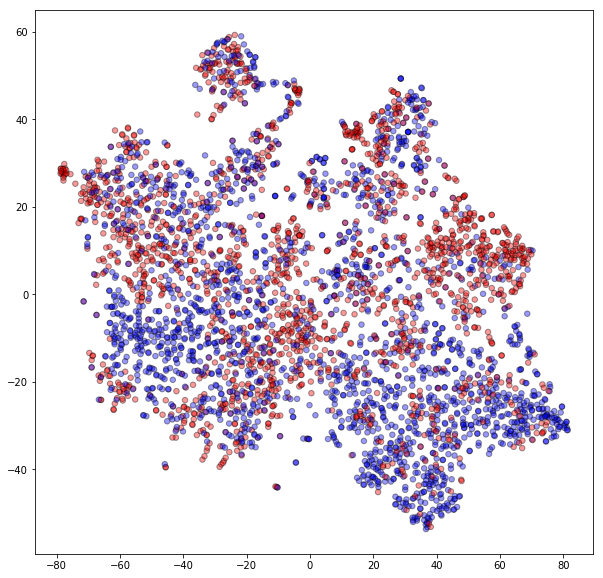

In [253]:
plt.figure(figsize=(10,10))

colors = np.array(["blue", "red"])
plt.scatter(x, y, alpha=0.4, c=colors[all_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

In [95]:
min_count = len(bank_min_df) + len(fr_min_df) + len(comm_min_df)
maj_count = len(bank_maj_df) + len(fr_maj_df) + len(comm_maj_df)
min_count, maj_count

(2085, 1811)

In [164]:
fr_arr = [fr_maj_df, fr_min_df]

In [171]:
fr_df = pd.concat(fr_arr).reset_index().drop("index", axis=1)
fr_df["Topic_Score"] = fr_df.apply(lambda row: get_rel_score(row["Release"]), axis=1)

In [185]:
fr_releases = list(fr_df["Topic_Score"])

In [186]:
test_kmeans = KMeans(n_clusters=2)
test_kmeans.fit_predict(fr_releases)

ValueError: setting an array element with a sequence.

In [190]:
test_df = all_df[["Label", "Topic_Score"]]
pd.get_dummies(test_df, columns=["Label"])

,Topic_Score,"Label_Banking, Democratic","Label_Banking, Republican","Label_Commerce, Democratic","Label_Commerce, Republican","Label_Foreign Relations, Democratic","Label_Foreign Relations, Republican"
0,"[0.132771266865, 0.163750511893, 0.10224109906...",0,0,0,0,0,1
1,"[0.161836454371, 0.17799742471, 0.008777799282...",0,0,0,0,0,1
2,"[0.215197382818, 0.0895894397549, 0.0094056595...",0,0,0,0,0,1
3,"[0.282134728994, 0.222074805159, 0.02188816486...",0,0,0,0,0,1
4,"[0.107043760938, 0.0458559777496, 0.1090062981...",0,0,0,0,0,1
5,"[0.110378391454, 0.280921275607, 0.01450097725...",0,0,0,0,0,1
6,"[0.0463834431355, 0.146295225502, 0.1925549346...",0,0,0,0,0,1
7,"[0.150809249264, 0.0853150247797, 0.0009371635...",0,0,0,0,0,1
8,"[0.209973498372, 0.303223559131, 0.00320713788...",0,0,0,0,0,1
9,"[0.129568783877, 0.326918783009, 0.0, 0.0, 0.0...",0,0,0,0,0,1


In [191]:
def get_party_classification(party):
    if party == "Democratic":
        return 0
    else:
        return 1

In [193]:
all_df["Party_Classification"] = all_df.apply(lambda row: get_party_classification(row["Party"]), axis=1)

In [195]:
model = KMeans(n_clusters=2)

In [237]:
scores = pd.DataFrame(list(all_df.Topic_Score))
scores = scores.fillna(0)

In [209]:
model.fit(scores)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [243]:
type(results1)

numpy.ndarray

In [215]:
results1 = tsne_model.fit_transform(scores)

In [216]:
model.fit(results1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [217]:
model.labels_

array([1, 1, 0, ..., 0, 0, 0], dtype=int32)

In [218]:
Counter(model.labels_)

Counter({0: 1934, 1: 1962})

In [219]:
x1, y1 = get_coords(results1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


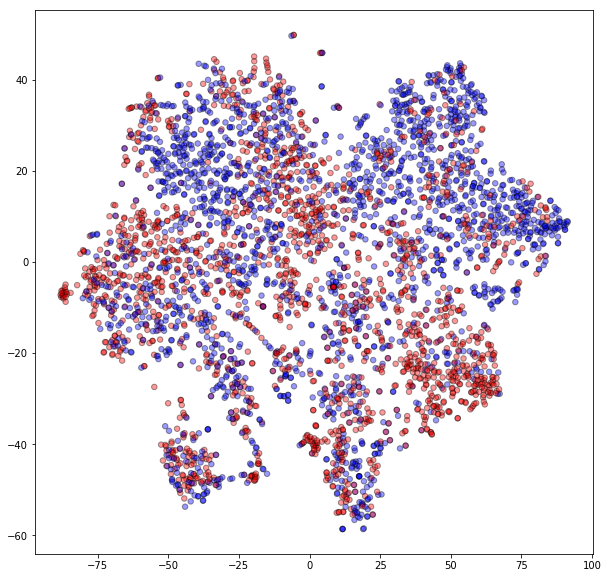

In [252]:
plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(x1, y1, alpha=0.4, c=colors[all_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

In [224]:
kmeans.labels_

array([0, 0, 4, ..., 4, 4, 1], dtype=int32)

In [230]:
all_df.Party.value_counts()

Democratic    2085
Republican    1811
Name: Party, dtype: int64

### Foreign Relations Clustering

###### 30 Topics

In [233]:
fr_df["Party_Classification"] = fr_df.apply(lambda row: get_party_classification(row["Party"]), axis=1)

In [234]:
fr_model = KMeans(n_clusters=2)


In [240]:
fr_scores = pd.DataFrame(list(all_df.Topic_Score))
fr_scores = fr_scores.fillna(0)
#fr_scores

In [245]:
fr_model.fit(fr_scores)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [343]:
fr_tsne = tsne_model.fit_transform(fr_scores)

ValueError: X should be a square distance matrix

In [242]:
fr_x, fr_y = get_coords(fr_tsne)

pandas.core.frame.DataFrame

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


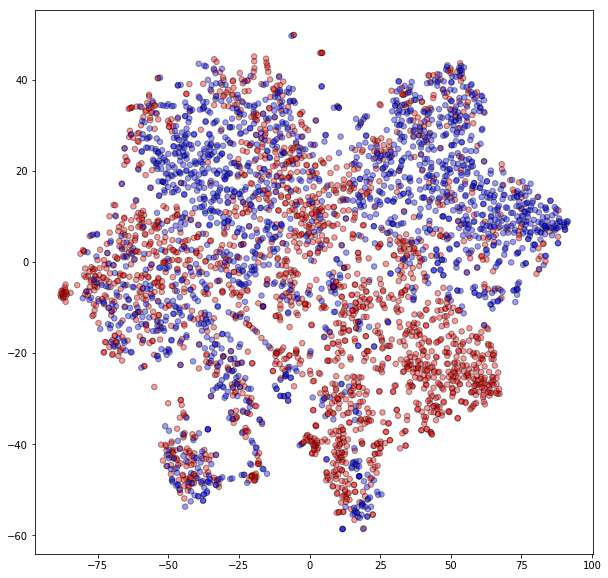

In [251]:
plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(fr_x, fr_y, alpha=0.4, c=colors[fr_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

In [248]:
len(fr_min_df)

910

In [249]:
Counter(fr_model.labels_)

Counter({0: 1087, 1: 2809})

In [250]:
len(fr_df)

1970

In [264]:
polarity = []
for release in list(fr_df.Release):
    x = TextBlob(release)
    polarity.append(x.polarity)

In [268]:
np.argmin(polarity)

239

In [269]:
polarity[239]

-0.5125000000000001

In [274]:
sorted(polarity)
arr = list(fr_df.Release)

[' United States Senate Committee on Foreign Relations Hearing: Corruption: Violent Extremism, Kleptocracy, and the Dangers of Failing Governance ']

##### 150 Topics

In [323]:
fr_df = all_df[all_df.Committee == "Foreign Relations"]
fr_scores = pd.DataFrame(list(fr_df.Topic_Score))

In [324]:
fr_scores

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.420341,0.356229,0.000000,0.053970,0.003016,0.012252,0.000251,0.053650,0.000000,0.012183,...,0.000152,0.000048,0.000000,0.000230,0.001985,0.000218,0.022253,0.024750,0.045801,0.004189
1,0.281104,0.415753,0.000912,0.001465,0.095865,0.000872,0.001099,0.074371,0.000118,0.000522,...,0.000545,0.008343,0.000603,0.008377,0.000005,0.000086,0.000592,0.005504,0.050308,0.001390
2,0.075437,0.155173,0.278014,0.003526,0.084896,0.030918,0.093616,0.046241,0.000000,0.023961,...,0.010372,0.007124,0.000598,0.003084,0.000000,0.006373,0.000060,0.003108,0.000924,0.007138
3,0.733320,0.448527,0.002227,0.000000,0.000000,0.000000,0.000000,0.000136,0.000000,0.000000,...,0.000331,0.000305,0.000000,0.038119,0.000000,0.000000,0.000052,0.000000,0.000000,0.000000
4,0.071966,0.102685,0.000540,0.001550,0.000000,0.000000,0.005186,0.286533,0.000644,0.004000,...,0.000256,0.000061,0.000757,0.006634,0.000144,0.002756,0.000533,0.039568,0.001402,0.000455
5,0.451716,0.646670,0.003446,0.000000,0.000000,0.000000,0.001529,0.000586,0.000000,0.000000,...,0.005047,0.042345,0.000000,0.062407,0.000000,0.018781,0.001073,0.000000,0.001804,0.000000
6,0.169395,0.404095,0.002296,0.053431,0.002815,0.010088,0.005253,0.060732,0.000000,0.007037,...,0.000766,0.000000,0.000000,0.001051,0.001472,0.000229,0.020566,0.080774,0.044299,0.003734
7,0.096139,0.276847,0.000812,0.000000,0.000000,0.087516,0.266866,0.000174,0.000170,0.000377,...,0.000013,0.014533,0.074128,0.003169,0.001150,0.002261,0.000087,0.000352,0.000133,0.001007
8,0.479512,0.696510,0.705685,0.000000,0.000000,0.309047,0.002594,0.000053,0.000098,0.000432,...,0.000000,0.000000,0.000000,0.065267,0.000000,0.012260,0.000349,0.000792,0.000564,0.000876
9,0.518482,0.758710,0.000000,0.000000,0.000000,0.000000,0.006680,0.000464,0.000000,0.000000,...,0.001857,0.000000,0.001010,0.064870,0.000000,0.010167,0.001010,0.000000,0.000000,0.000000


In [328]:
fr_scores =fr_scores.fillna(0)

In [349]:
fr_tsne = tsne_model.fit_transform(fr_scores)

In [350]:
fr_x, fr_y = get_coords(fr_tsne)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


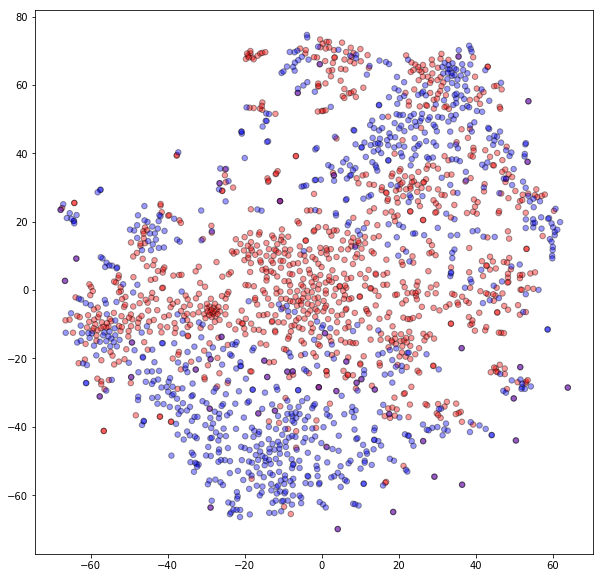

In [351]:
plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(fr_x, fr_y, alpha=0.4, c=colors[fr_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

#### Commerce Modeling

In [332]:
comm_df = all_df[all_df.Committee == "Commerce"]

In [333]:
commerce_scores = pd.DataFrame(list(comm_df.Topic_Score))
commerce_scores = commerce_scores.fillna(0)

In [280]:
comm_model = KMeans(n_clusters=6)

In [352]:
comm_results = tsne_model.fit_transform(commerce_scores)

In [353]:
comm_x, comm_y = get_coords(comm_results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


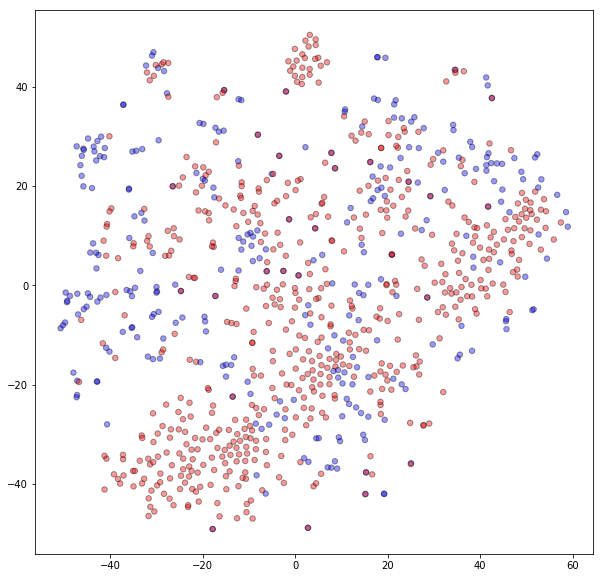

In [354]:
plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(comm_x, comm_y, alpha=0.4, c=colors[comm_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

585

#### Banking Modeling

In [337]:
bank_df = all_df[all_df.Committee == "Banking"]

In [355]:
bank_scores = pd.DataFrame(list(bank_df.Topic_Score))
bank_scores = bank_scores.fillna(0)
bank_results = tsne_model.fit_transform(bank_scores)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


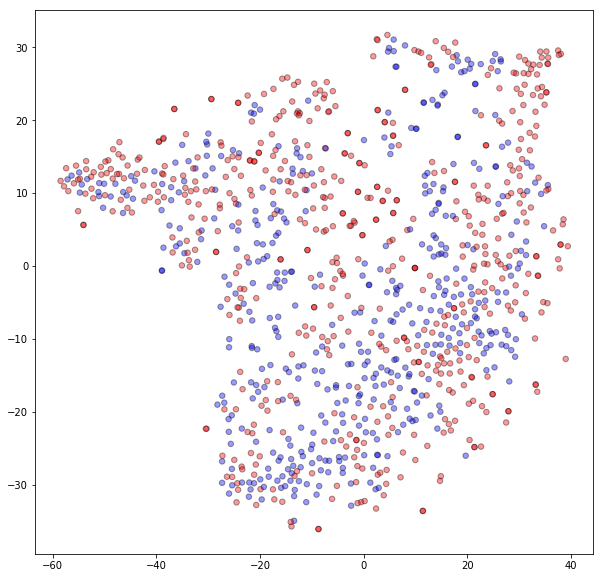

In [339]:
bank_x, bank_y = get_coords(bank_results)
plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(bank_x, bank_y, alpha=0.4, c=colors[comm_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()